# Lab 4 - Linear models

We focus on models in the form 

$$ y \sim \mathrm{Normal}(\alpha+X\beta,\sigma) $$



In [12]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [13]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [14]:
mean = d['height'].mean()
std_dev = d['height'].std()
print("Mean: ", mean)
print("Std: ", std_dev)

Mean:  154.5970926136364
Std:  7.742332137351995


## Task 1. Prior predictive checks

In [15]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.




1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors.
4. Correct prior parameters to make them reasonably spreaded out. 
5. Check if observed data is possible to obtain using priors.

In [16]:
dataframe = sim.draws_pd()
dataframe.head()

,lp__,accept_stat__,mu,sigma,height
0,0.0,0.0,175.561,8.12614,161.365
1,0.0,0.0,158.718,70.33170,267.843
2,0.0,0.0,151.796,11.77890,159.523
3,0.0,0.0,156.381,19.51800,191.750
4,0.0,0.0,144.690,4.67849,152.058


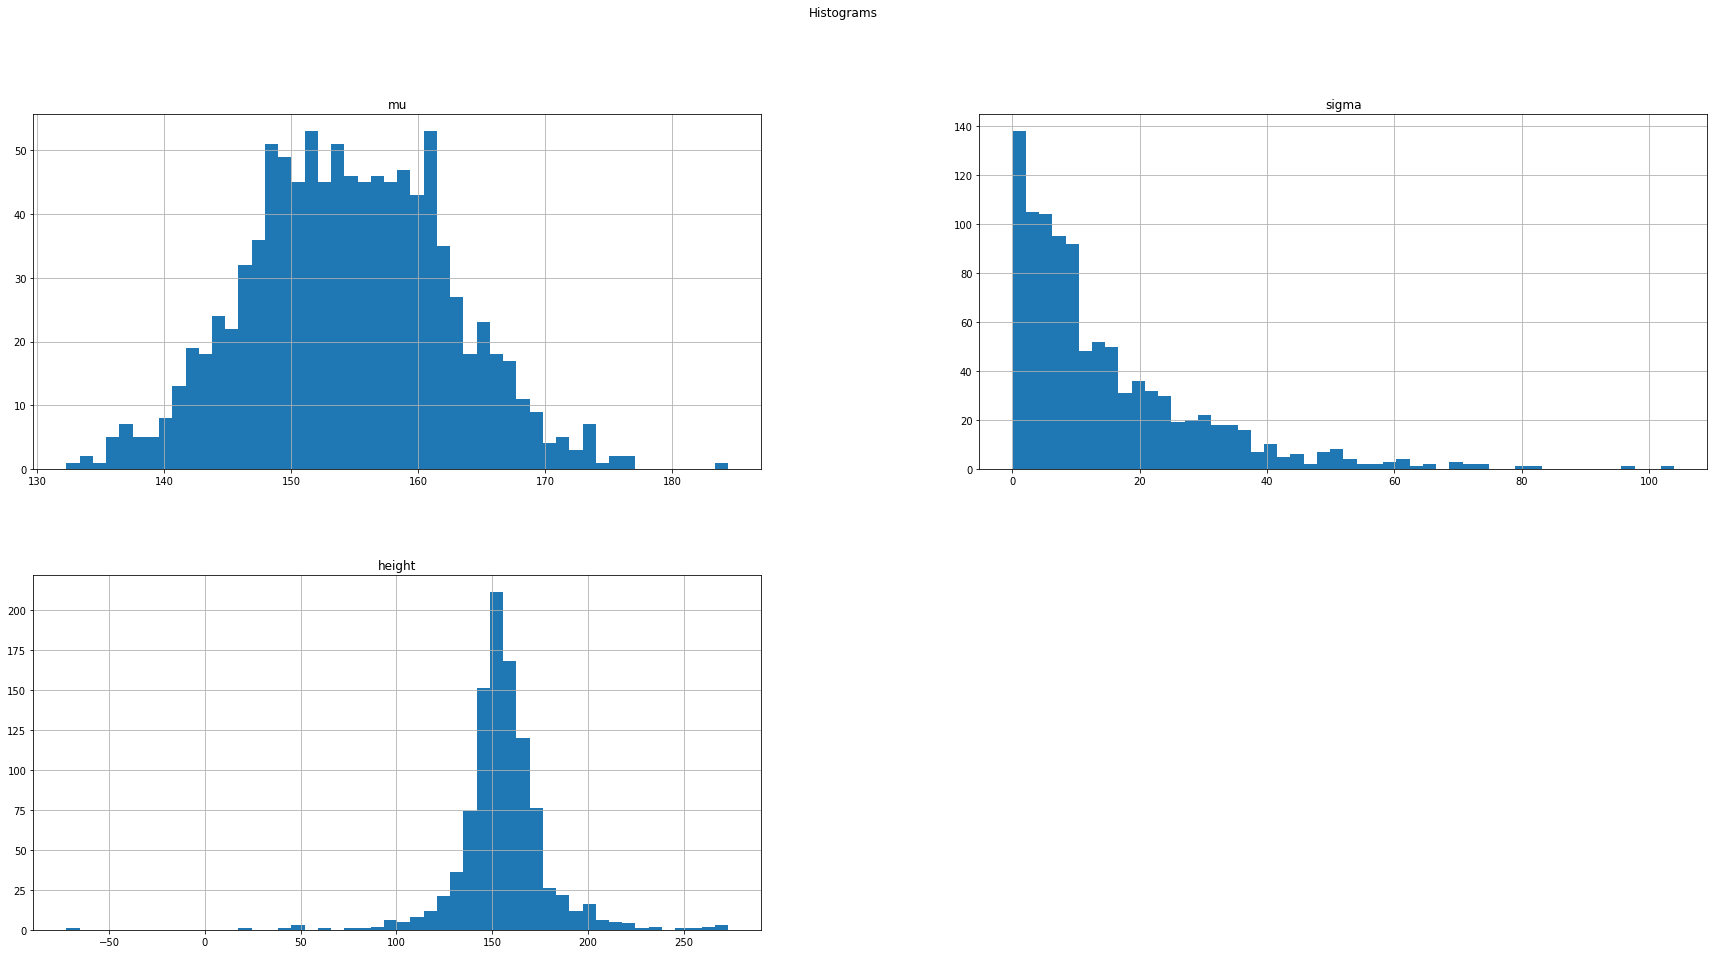

In [17]:
dataframe = dataframe[dataframe.columns[2:5]]

dataframe.hist(bins=50, figsize=(30, 15))
plt.suptitle("Histograms")
plt.show()

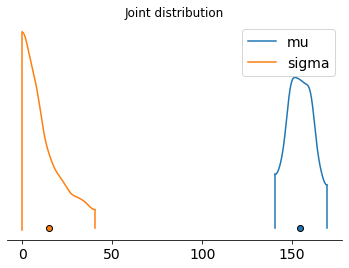

In [18]:
az.plot_density([sim.stan_variable('mu'), sim.stan_variable('sigma')], data_labels=["mu", "sigma"])
plt.title("Joint distribution")
plt.show()

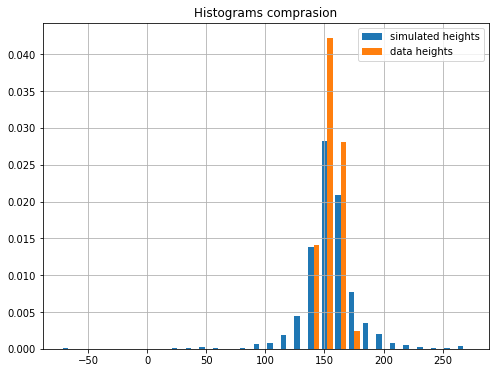

In [19]:
fig, ax = plt.subplots(figsize=(8, 6), sharex=True, sharey=True)
ax.hist([dataframe['height'], d['height']], bins = 30, density=True, label=['simulated heights', 'data heights'])
plt.title("Histograms comprasion")
plt.legend()
plt.grid()
plt.show()

## Task 2. Model fit and evaluation

In [20]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [21]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.



1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.


In [22]:
dataframe = fit.draws_pd()
dataframe.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,height
0,-895.580,0.755535,0.941456,1.0,3.0,0.0,895.854,154.472,7.32037,148.927
1,-897.238,0.877859,0.941456,2.0,3.0,0.0,897.344,154.308,7.12350,158.452
2,-895.269,1.000000,0.941456,2.0,7.0,0.0,896.842,154.536,8.13254,144.692
3,-896.477,0.534449,0.941456,2.0,3.0,0.0,900.940,155.410,7.63425,159.386
4,-898.554,0.780616,0.941456,2.0,3.0,0.0,899.660,153.417,7.94567,145.140


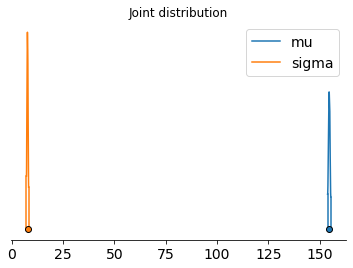

In [23]:
az.plot_density([fit.stan_variable('mu'), fit.stan_variable('sigma')], data_labels=["mu", "sigma"])
plt.title("Joint distribution")
plt.show()

In [24]:
height_sim = dataframe["height"]
height_data = d.height
height = pd.concat([height_sim, height_data], axis=1)
height.columns = ["simulated heights", "data heights"]
height.head()

,simulated heights,data heights
0,148.927,151.765
1,158.452,139.700
2,144.692,136.525
3,159.386,156.845
4,145.140,145.415


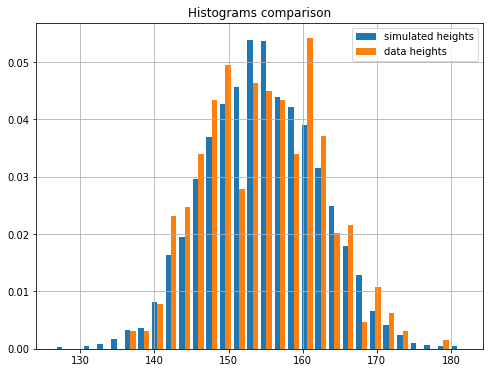

In [25]:
fig, ax = plt.subplots(figsize=(8, 6), sharex=True, sharey=True)
ax.hist([height['simulated heights'], height['data heights']], bins = 30, density=True, label=['simulated heights', 'data heights'])
plt.title("Histograms comparison")
plt.legend()
plt.grid()
plt.show()

## Task 3. Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [26]:
d["c_weight"] = d.weight - d.weight.mean()
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}

## Task 4. Prior predictive checks
 

In [27]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [28]:
dataframe = sim.draws_pd()
dataframe.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,175.561,7.771810,23.208300,70.3433,40.1990,83.2212,110.3920,140.2090,...,296.8890,318.6640,315.7570,291.12400,258.0690,282.7200,293.9650,323.0690,317.0280,330.4080
1,0.0,0.0,145.320,-0.067795,0.086958,146.3700,146.2860,146.2400,146.2340,146.1930,...,144.7300,144.4510,144.3310,144.35100,144.2380,144.3210,144.1420,144.1800,144.2570,144.0930
2,0.0,0.0,151.295,-11.386400,20.358900,338.6250,298.5380,291.6880,299.8540,288.1360,...,48.6791,-21.3263,29.0503,-2.33295,23.2724,-23.8107,-11.1728,-29.7067,-47.0776,-49.3374
3,0.0,0.0,146.998,-2.544520,6.415610,190.9430,176.5260,177.7040,171.3270,174.3700,...,119.6940,115.4470,115.3090,120.34400,106.6590,104.7470,111.8920,101.4350,105.4520,98.9051
4,0.0,0.0,146.911,16.710200,9.955320,-111.6710,-80.6869,-71.7171,-60.7306,-29.2542,...,365.4060,373.6910,364.2510,384.19000,391.9300,399.6970,409.7830,433.5020,442.5710,439.6270


In [29]:
alpha = dataframe["alpha"]
beta = dataframe["beta"]

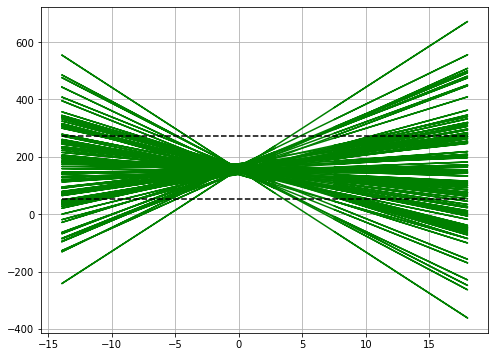

In [30]:
plt.figure(figsize=(8, 6))
for i in range(0, 100):
    plt.plot(d.c_weight, d.c_weight*beta[i] + alpha[i], color = "g")
plt.hlines([54, 272], xmin = d.c_weight.min(), xmax = d.c_weight.max(), colors="k", linestyles="--")
plt.grid()
plt.show()

In [31]:
sim_heights = dataframe[dataframe.columns[5:55]].values
print("Predicted maximum height: ", sim_heights.max())
print("Predicted minimum height: ", sim_heights.min())

Predicted maximum height:  774.74
Predicted minimum height:  -487.496


Predicted max and min heights are not consistent with maximum (272 [cm]) and minimum (54,6 [cm]) observed in nature.

## Task 5. Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [32]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [33]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [34]:
dataframe = sim.draws_pd()
dataframe.head()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
0,0.0,0.0,175.561,2.175330,23.208300,148.2430,114.4530,153.8290,177.3540,203.5250,...,228.953,247.082,240.530,212.251,175.550,196.555,204.154,229.613,219.926,229.660
1,0.0,0.0,145.320,0.993243,0.086958,131.6010,132.2080,132.8530,133.5390,134.1890,...,157.610,158.022,158.593,159.305,159.883,160.657,161.169,161.898,162.667,163.194
2,0.0,0.0,151.295,0.320255,20.358900,175.6750,143.2140,143.9910,159.7830,155.6920,...,190.786,128.407,186.410,162.653,195.885,156.428,176.692,165.785,156.040,161.407
3,0.0,0.0,146.998,0.775342,6.415610,144.7320,132.4780,135.8190,131.6050,136.8110,...,159.994,157.909,159.934,167.132,155.609,155.861,165.168,156.874,163.054,158.670
4,0.0,0.0,146.911,5.317560,9.955320,46.9071,70.4697,72.0177,75.5824,99.6369,...,227.112,227.975,211.114,223.630,223.948,224.293,226.958,243.255,244.902,234.537


In [35]:
alpha = dataframe["alpha"]
beta = dataframe["beta"]

1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

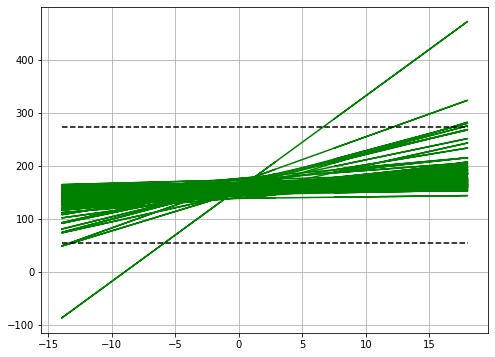

In [36]:
plt.figure(figsize=(8, 6))
for i in range(0, 100):
    plt.plot(d.c_weight, d.c_weight*beta[i] + alpha[i], color = "g")
plt.hlines([54, 272], xmin = d.c_weight.min(), xmax = d.c_weight.max(), colors="k", linestyles="--")
plt.grid()
plt.show()

In [37]:
sim_heights = dataframe[dataframe.columns[5:55]]
print("Predicted maximum height: ", sim_heights.values.max())
print("Predicted minimum height: ", sim_heights.values.min())

Predicted maximum height:  629.251
Predicted minimum height:  -222.337


Predicted max and min heights are completely inconsistent with maximum (272 [cm]) and minimum (54,6 [cm]) observed in nature.

2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

Text(0.5, 1.0, 'Observed data quantiles')

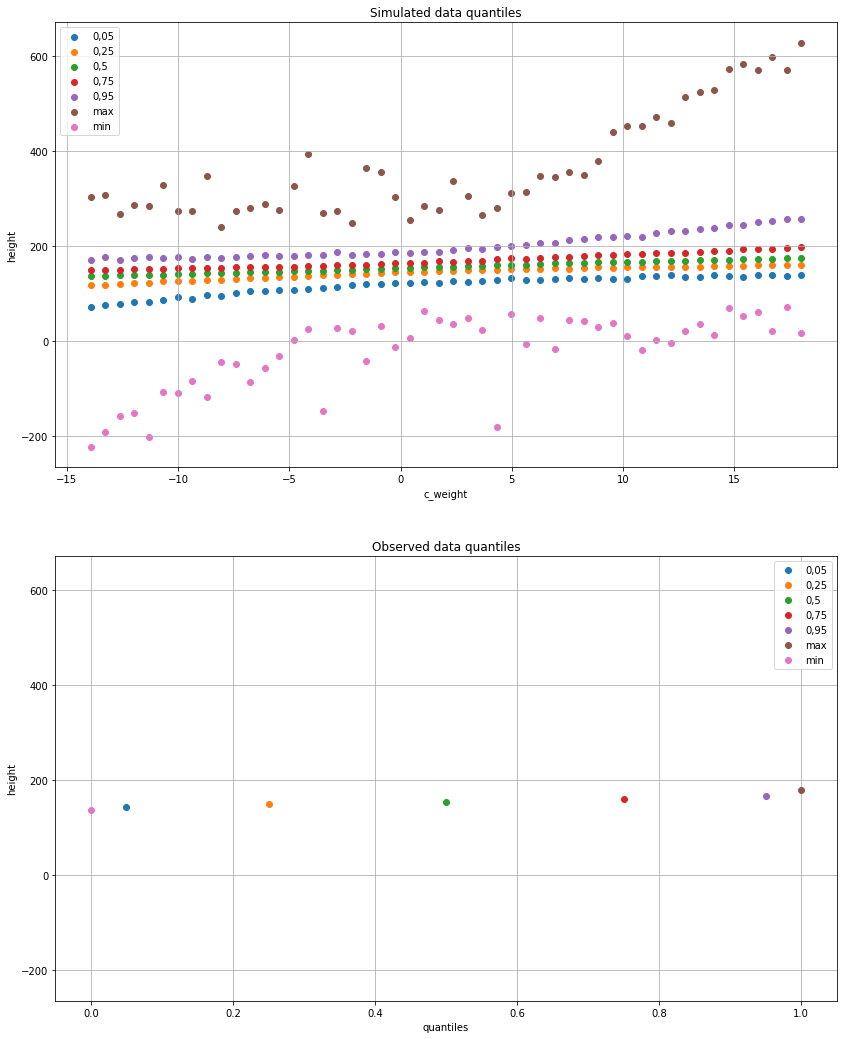

In [38]:
quantiles_value = [0.05, 0.25, 0.5, 0.75, 0.95]
calculated_quantiles = np.quantile(sim_heights, quantiles_value, axis=0)
max_heights = []
min_heights = []
for col in sim_heights:
    max_heights.append(sim_heights[col].max())
    min_heights.append(sim_heights[col].min())

calculated_quantiles = np.vstack([calculated_quantiles, max_heights])
calculated_quantiles = np.vstack([calculated_quantiles, min_heights])
weights = np.linspace(d.c_weight.min(), d.c_weight.max())
legend = ['0,05', '0,25', '0,5', '0,75', '0,95', 'max', 'min']

plt.figure(figsize=(14, 18))
ax1 = plt.subplot(2, 1, 1)
for i in range(calculated_quantiles.shape[0]):
    plt.scatter(weights, calculated_quantiles[i], label=legend[i])
plt.grid()
plt.legend()
plt.xlabel("c_weight")
plt.ylabel("height")
plt.title("Simulated data quantiles")

observed_quantiles = np.quantile(d.height, quantiles_value, axis=0)
max_heights = d.height.max()
min_heights = d.height.min()

plt.subplot(2, 1, 2, sharey=ax1)
for i in range(len(quantiles_value)):
    plt.plot(quantiles_value[i], observed_quantiles[i], 'o', label=legend[i], linewidth=4)
plt.plot(1, max_heights, 'o', label='max', linewidth=4)
plt.plot(0, min_heights, 'o', label='min', linewidth=4)
plt.grid()
plt.legend()
plt.xlabel("quantiles")
plt.ylabel("height")
plt.title("Observed data quantiles")

Observed data is possible within the prior model

## Task 6. Fitting and evaluating model


In [39]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe


In [40]:
N = 150
d_N = d.head(N)
data_fit = {'N': N, 'weight': d_N.weight.values, 'heights': d_N.height.values}
fit=model_2_fit.sample(data=data_fit,seed=28052020)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [41]:
dataframe = fit.draws_pd()
dataframe.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,height[141],height[142],height[143],height[144],height[145],height[146],height[147],height[148],height[149],height[150]
0,-343.718,0.996778,0.104993,5.0,31.0,0.0,346.523,120.864,0.721671,6.22505,...,153.537,150.407,162.204,152.937,146.638,152.326,166.140,149.816,152.545,156.302
1,-344.464,0.877464,0.104993,2.0,3.0,0.0,345.244,121.531,0.746073,6.17337,...,148.007,166.076,152.742,160.087,154.459,162.767,166.575,149.758,157.962,157.196
2,-342.677,0.991141,0.104993,4.0,31.0,0.0,346.719,119.123,0.794918,5.80762,...,148.259,145.102,148.415,142.953,153.789,150.889,162.775,144.234,156.682,152.733
3,-343.981,0.997084,0.104993,5.0,63.0,0.0,344.758,123.656,0.696360,6.04182,...,154.013,152.556,154.856,156.345,155.372,166.863,152.179,150.786,157.841,140.765
4,-341.105,0.994952,0.104993,4.0,31.0,0.0,345.469,121.211,0.724917,5.50279,...,155.558,147.701,156.675,148.749,148.335,161.746,150.765,154.587,148.256,148.758


2. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)

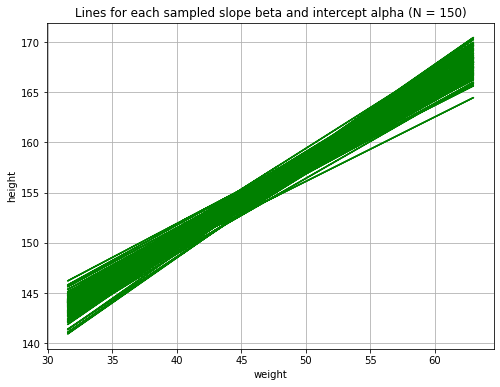

In [42]:
alpha = dataframe["alpha"]
beta = dataframe["beta"]

plt.figure(figsize=(8, 6))
for i in range(0, 100):
    plt.plot(d_N.weight, d_N.weight * beta[i] + alpha[i], color = "g")
plt.grid()
plt.xlabel('weight')
plt.ylabel('height')
plt.title(f'Lines for each sampled slope beta and intercept alpha (N = {N})')
plt.show()

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


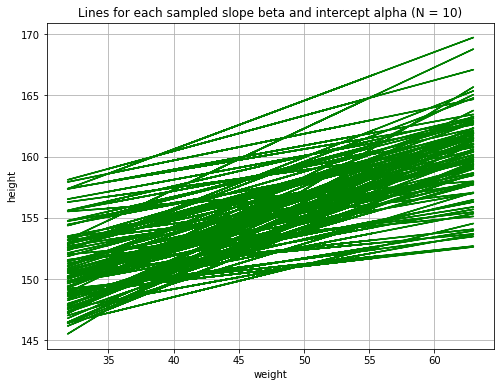

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


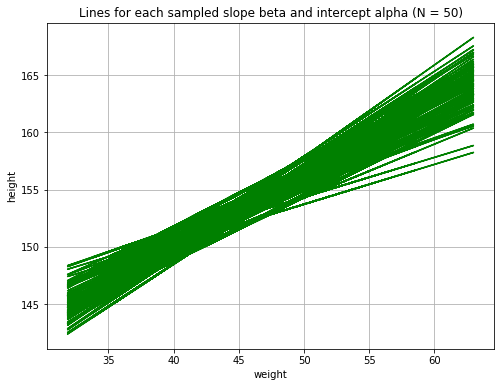

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


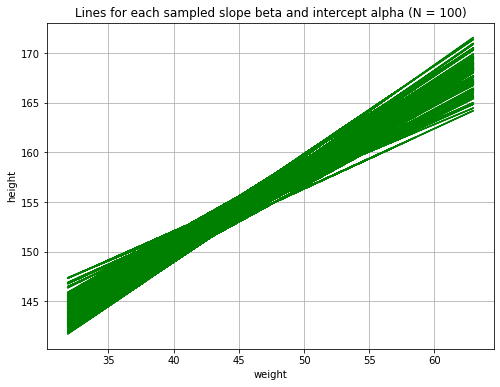

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


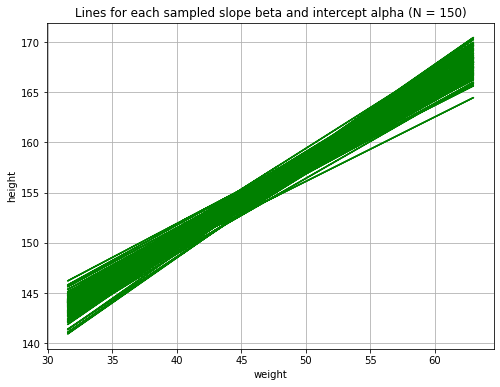

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


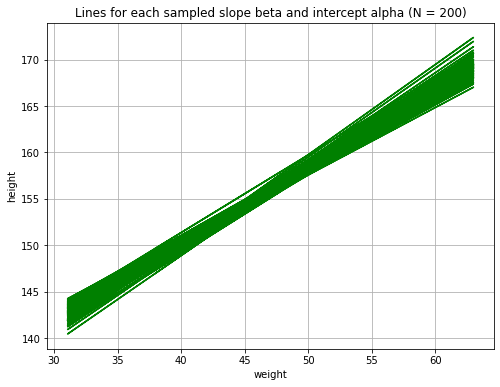

In [43]:
N_ = [10, 50, 100, 150, 200]

for N in N_:
    d_N = d.head(N)
    data_fit = {'N': N, 'weight': d_N.weight.values, 'heights': d_N.height.values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    
    dataframe = fit.draws_pd()
    alpha = dataframe["alpha"]
    beta = dataframe["beta"]
    
    plt.figure(figsize=(8, 6))
    for i in range(0, 100):
        plt.plot(d_N.weight, d_N.weight * beta[i] + alpha[i], color = "g")
    plt.grid()
    plt.xlabel('weight')
    plt.ylabel('height')
    plt.title(f'Lines for each sampled slope beta and intercept alpha (N = {N})')
    plt.show()    

Uncertainty decreases with increasing of N value.

3. For each value of weight plot mean simulated height along with errorbar of one standard deviation (use ```errorbar``` from matplotlib). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


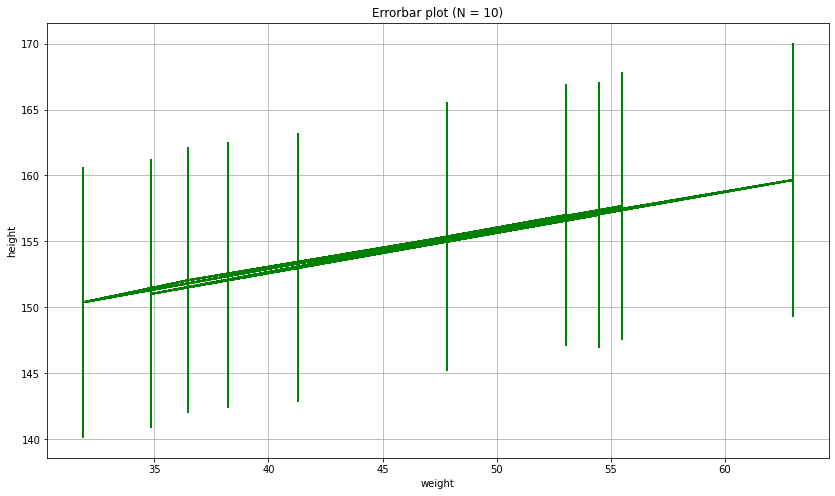

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


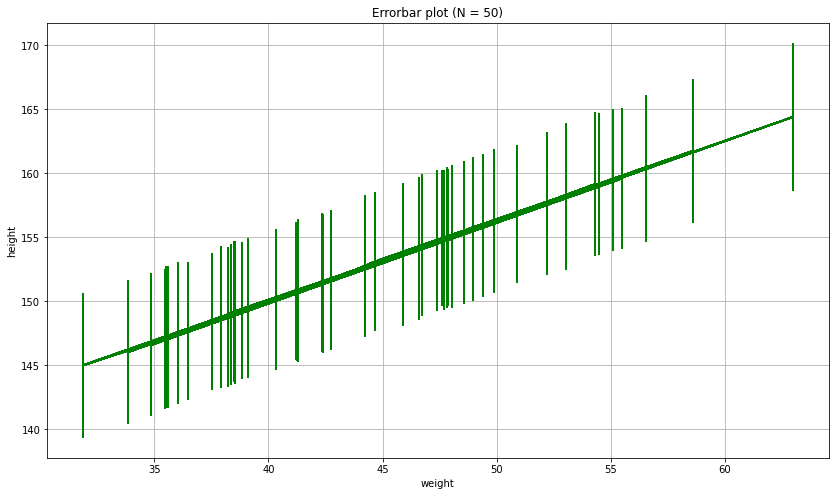

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


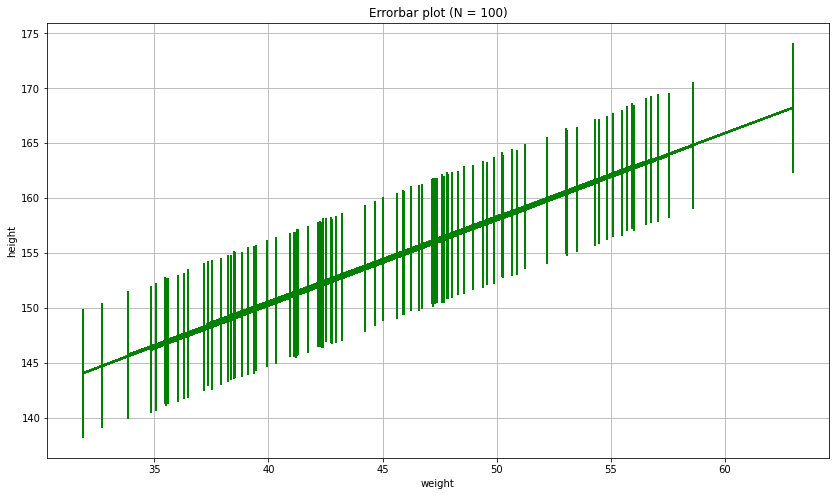

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


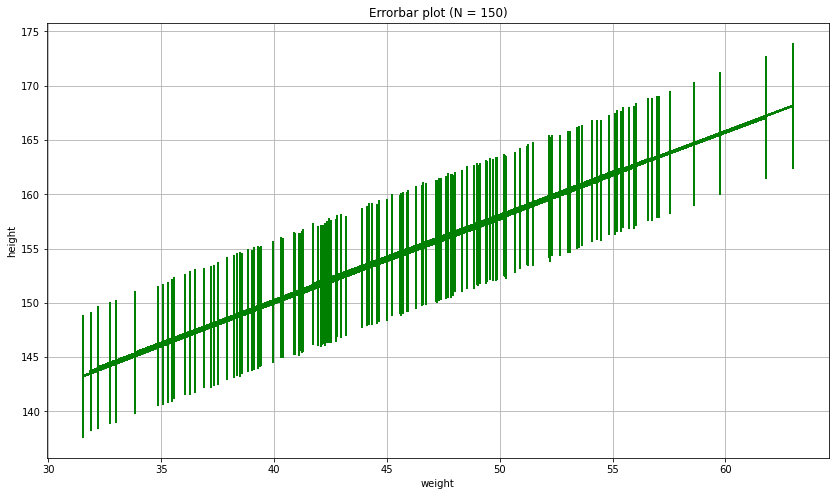

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


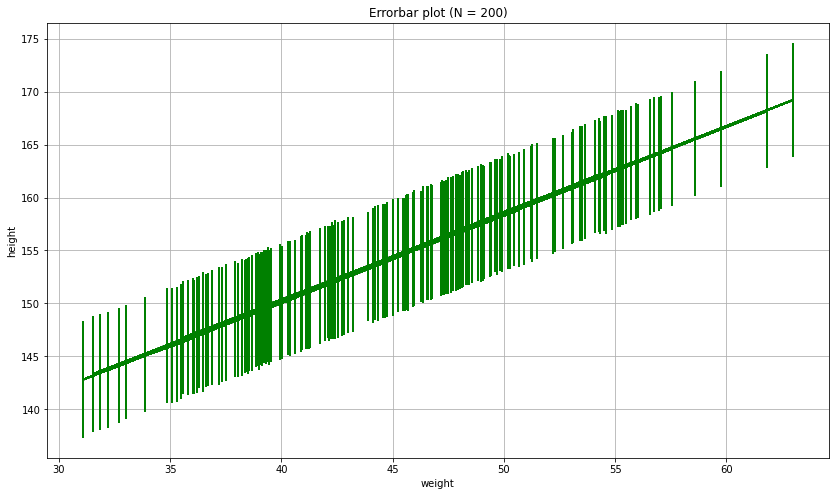

In [44]:
N_ = [10, 50, 100, 150, 200]

for N in N_:
    d_N = d.head(N)
    data_fit = {'N': N, 'weight': d_N.weight.values, 'heights': d_N.height.values}
    fit=model_2_fit.sample(data=data_fit,seed=28052020)
    
    dataframe = fit.draws_pd()
    alpha = dataframe["alpha"]
    beta = dataframe["beta"]
    height_ = fit.stan_variable("height")
    height_mean = height_.mean(axis=0)
    height_std = height_.std(axis=0)

    plt.figure(figsize=(14, 8))
    for i in range(0, 100):
        pass
        plt.errorbar(d_N.weight, height_mean, height_std, color = "g")
    plt.grid()
    plt.xlabel('weight')
    plt.ylabel('height')
    plt.title(f'Errorbar plot (N = {N})')
    plt.show()   

Errorbar height decreases with increasing of N value.

## Task 7. Extending the model

1. Center the weight data (substract mean vaule of weight from all values). Test how model works for such data. What is the interpretation of $\alpha$ in such case?

In [45]:
N = 100
d_N = d.head(N)
data_fit = {'N': N, 'weight': d_N.c_weight.values, 'heights': d_N.height.values}
fit=model_2_fit.sample(data=data_fit,seed=28052020) 

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [46]:
dataframe = fit.draws_pd()
dataframe.head()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,height[91],height[92],height[93],height[94],height[95],height[96],height[97],height[98],height[99],height[100]
0,-220.685,0.784957,0.791079,2.0,3.0,0.0,222.294,154.291,1.121840,5.63441,...,167.989,164.115,146.950,153.976,143.452,166.353,149.794,159.743,158.911,154.069
1,-222.802,0.870612,0.791079,2.0,3.0,0.0,223.857,154.265,1.134580,6.41060,...,162.781,164.717,147.094,158.204,146.297,161.997,153.988,166.484,166.627,152.647
2,-218.997,1.000000,0.791079,2.0,3.0,0.0,222.791,153.509,0.918912,5.38793,...,164.199,168.105,152.920,153.848,155.633,166.122,150.278,172.916,162.545,156.033
3,-219.399,0.975416,0.791079,2.0,3.0,0.0,219.761,153.285,0.973348,5.29885,...,166.959,155.818,151.952,159.601,146.283,174.090,143.250,155.759,163.806,145.292
4,-220.279,0.945105,0.791079,2.0,3.0,0.0,220.986,154.578,1.064000,5.17810,...,161.459,163.409,145.677,166.907,154.865,158.522,153.544,166.216,166.752,150.445


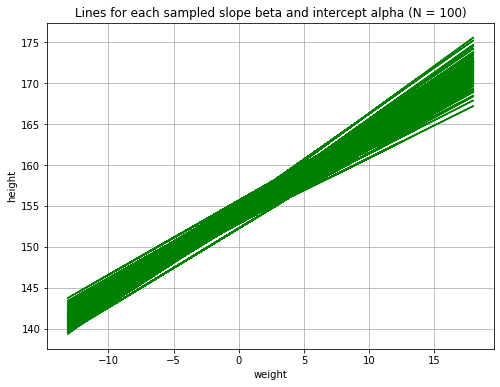

In [47]:
alpha = dataframe["alpha"]
beta = dataframe["beta"]

plt.figure(figsize=(8, 6))
for i in range(0, 100):
    plt.plot(d_N.c_weight, d_N.c_weight * beta[i] + alpha[i], color = "g")
plt.grid()
plt.xlabel('weight')
plt.ylabel('height')
plt.title(f'Lines for each sampled slope beta and intercept alpha (N = {N})')
plt.show()  

2. Using centered data modify your model with a second power of weight, select prior for its coefficient using prior predictive checks and after fitting check if model is still good.

In [48]:
model_2_fit_7=CmdStanModel(stan_file='height_2_fit_7.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


3. Try to vectorize the model to avoid necessity of a for loop in the ```model``` block.

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


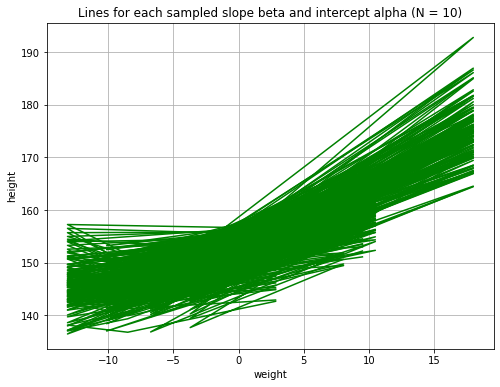

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


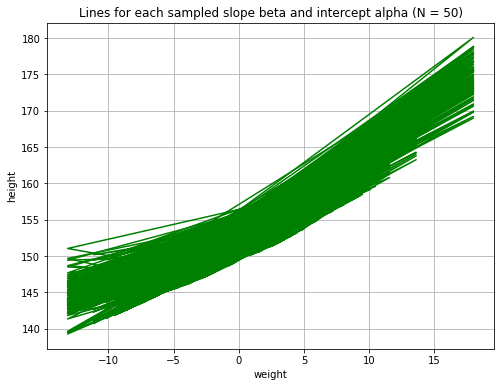

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


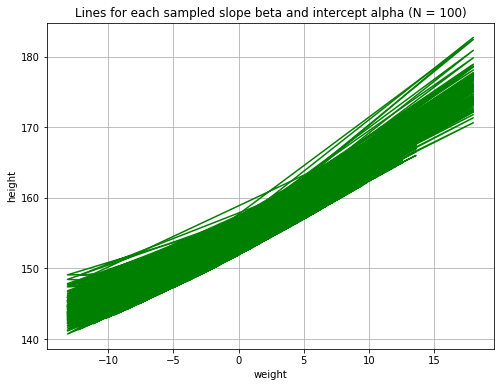

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


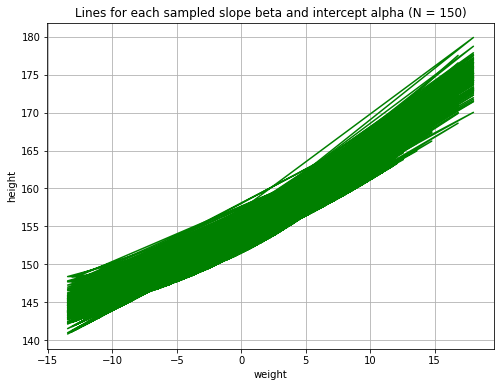

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


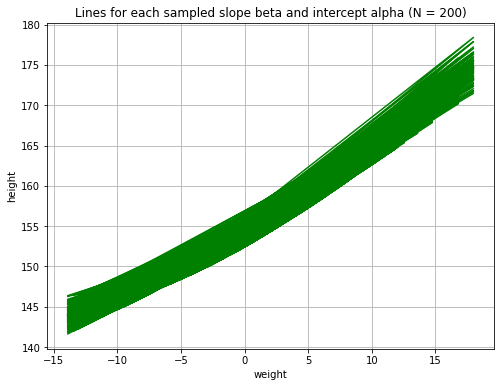

In [49]:
N_ = [10, 50, 100, 150, 200]

for N in N_:
    d_N = d.head(N)
    data_fit = {'N': N, 'weight': d_N.c_weight.values, 'heights': d_N.height.values}
    fit=model_2_fit_7.sample(data=data_fit,seed=28052020)
    
    dataframe = fit.draws_pd()
    alpha = dataframe["alpha"]
    beta = dataframe["beta"]
    gamma = dataframe["gamma"]
    
    plt.figure(figsize=(8, 6))
    for i in range(0, 100):
        plt.plot(d_N.c_weight, d_N.c_weight * beta[i] + alpha[i] + gamma[i] * np.power(d_N.c_weight, 2), color = "g")
    plt.grid()
    plt.xlabel('weight')
    plt.ylabel('height')
    plt.title(f'Lines for each sampled slope beta and intercept alpha (N = {N})')
    plt.show()  

Model appears to be correct